# Annular Collision Probabilities Pin Cell Problem

In this example, we will look at simulating a single UO2 pin-cell using the annular collision probabilities solver in Scarabée. To start, we will load the libraries we will be using, and initialize the nuclear data library object (`NDLibrary`) which contains the nuclear data for the simulation. We will be using the ENDF/B-VIII.0 library in the SHEM-281 group structure.

In [1]:
import scarabee as scrb
import numpy as np
import matplotlib.pyplot as plt

ndl = scrb.NDLibrary()

We will start by defining the materials for the simulation. Firstly, we will need fuel, which will be 3 w/o enriched UO2. Scarabée has several helper functions to facilitate this process:

In [2]:
UO2_comp = scrb.MaterialComposition(name="UO2")
UO2_comp.add_leu(enrichment=3., fraction=1.)
UO2_comp.add_element(name="O", fraction=2.)
UO2 = scrb.Material(UO2_comp, 800., 10.96, scrb.DensityUnits.g_cm3, ndl)

The `MaterialComposition.add_leu` method allows you to add low enriched Uranium up to 5 w/o to the material composition. The last line of this cell makes the final material object, where we have taken the fuel to be at a temperature of 800 K and a density of 10.96 g/cm$^3$. Next, we need natural He gas for the gap between the fuel pellet and the cladding:

In [3]:
He_comp = scrb.MaterialComposition(name="He")
He_comp.add_element("He", 1.)
He = scrb.Material(He_comp, 600., 1.66322E-4, scrb.DensityUnits.g_cm3, ndl)

Using the PNNL Materials Compendium, we can also create a material for Zircaloy-4 for the fuel rod cladding.

In [4]:
Zirc_comp = scrb.MaterialComposition(fractions=scrb.Fraction.Weight, name="Zircaoloy-4")
Zirc_comp.add_element("O", 0.001196)
Zirc_comp.add_element("Cr", 0.000997)
Zirc_comp.add_element("Fe", 0.001993)
Zirc_comp.add_element("Zr", 0.981859)
Zirc_comp.add_element("Sn", 0.013955)
Zirc = scrb.Material(Zirc_comp, 590., 6.56, scrb.DensityUnits.g_cm3, ndl)


Lastly, we need the moderator. We will use light water at 575 K under a pressure of 15.5 MPa and with 650 PPM boron. This is fairly representative of the moderator conditions one might find in a PWR. Scarabée has a helper function to generate such a water material for us at the correct density and nuclide fractions.

In [5]:
H2O = scrb.borated_water(temperature=575., pressure=15.5, boron_ppm=650., ndl=ndl)

We will assume that the fuel pellet has a radius of 0.3975 cm, the gap a radius of 0.4125 cm, and the cladding a radius of 0.4750 cm. The pin pitch is 1.26 cm. Since we can only simulate a cylindrical system of rings with white boundary conditions when using the annular collision probabilities solver, we need to determine the equivalent radius for our pin cell. If the pin pitch is denoted as $p$, then the equivalent radius $R_{cell}$ can be found with

$$
    p^2 = \pi R_{cell}^2
$$

$$
    R_{cell} = \frac{p}{\sqrt{\pi}}
$$

In [6]:
R_fuel = 0.3975
R_gap = 0.4125
R_clad = 0.4750
R_cell = 1.26 / np.sqrt(np.pi)

Before proceeding, we must first do the self-shielding calculations for the fuel and cladding. This requires the appropriate Dancoff corrections that account for shadowing in the fuel lattice. While Dancoff factors are best calculated for the true square geometry using the method of characteristics, we can get reasonable corrections using the annular collision probabilities solver for our use case here. To compute the Dancoff corrections we will use the neutron current method which requires four calculations in total (two for the fuel and two for the cladding). For each material, a simulation with an "isolated" fuel pin is performed, and then the "true" geometry. Additionally, for the non-resonant materials, the cross sections will only be the potential scattering cross section of the material. Here is the calculation for determining the fuel Dancoff correction:

In [7]:
# Define 1-group cross sections
Et = np.array([1.E5])
Ea = Et
Es = np.array([[0.]])
FuelXS = scrb.CrossSection(Et, Ea, Es)

Et = np.array([He.lambda_potential_xs])
Ea = Et
HeXS = scrb.CrossSection(Et, Ea, Es)

Et = np.array([Zirc.lambda_potential_xs])
Ea = Et
ZircXS = scrb.CrossSection(Et, Ea, Es)

Et = np.array([H2O.lambda_potential_xs])
Ea = Et
H2OXS = scrb.CrossSection(Et, Ea, Es)

# Define the cell geometry for an isolated pin
isolated_cell = scrb.CylindricalCell([R_fuel, R_gap, R_clad, 50.*R_cell], [FuelXS, HeXS, ZircXS, H2OXS])
isolated_cell.solve()

# Create the flux solver for the isolated pin
isolated_flux = scrb.CylindricalFluxSolver(isolated_cell)
isolated_flux.albedo = 0.
isolated_flux.sim_mode = scrb.SimulationMode.FixedSource
# Set the sources of the non-resonant materials to the potential xs
isolated_flux.set_extern_src(1, 0, HeXS.Et(0))
isolated_flux.set_extern_src(2, 0, ZircXS.Et(0))
isolated_flux.set_extern_src(3, 0, H2OXS.Et(0))
isolated_flux.solve()

# Define true cell geometry
true_cell = scrb.CylindricalCell([R_fuel, R_gap, R_clad, R_cell], [FuelXS, HeXS, ZircXS, H2OXS])
true_cell.solve()

# Solve flux for true pin
true_flux = scrb.CylindricalFluxSolver(true_cell)
true_flux.sim_mode = scrb.SimulationMode.FixedSource
true_flux.set_extern_src(1, 0, HeXS.Et(0))
true_flux.set_extern_src(2, 0, ZircXS.Et(0))
true_flux.set_extern_src(3, 0, H2OXS.Et(0))
true_flux.solve()

# Compute the Dancoff correction for the fuel
C_fuel = (isolated_flux.flux(0, 0) - true_flux.flux(0, 0)) / isolated_flux.flux(0, 0)
print("\nFuel Dancoff Correction: {:}".format(C_fuel))

[info] Solving cylindrical cell.
[info] Calculating collision probabilities.
[info] Solving system of equations for cylindrical cell.
[info] Solving for keff.
[info] keff tolerance: 1.00000E-05
[info] Flux tolerance: 1.00000E-05
[info] 
[info] Simulation Time: 1.64708E-03 s
[info] Solving cylindrical cell.
[info] Calculating collision probabilities.
[info] Solving system of equations for cylindrical cell.
[info] Solving for keff.
[info] keff tolerance: 1.00000E-05
[info] Flux tolerance: 1.00000E-05
[info] 
[info] Simulation Time: 1.46512E-03 s

Fuel Dancoff Correction: 0.3322517616608382


We follow a similar procedure to get the Dancoff correction for the cladding:

In [8]:
# Define 1-group cross sections
Et = np.array([UO2.lambda_potential_xs])
Ea = Et
Es = np.array([[0.]])
FuelXS = scrb.CrossSection(Et, Ea, Es)

Et = np.array([1.E5])
Ea = Et
ZircXS = scrb.CrossSection(Et, Ea, Es)

# Define the cell geometry for an isolated pin
isolated_cell = scrb.CylindricalCell([R_fuel, R_gap, R_clad, 50.*R_cell], [FuelXS, HeXS, ZircXS, H2OXS])
isolated_cell.solve()

# Create the flux solver for the isolated pin
isolated_flux = scrb.CylindricalFluxSolver(isolated_cell)
isolated_flux.albedo = 0.
isolated_flux.sim_mode = scrb.SimulationMode.FixedSource
# Set the sources of the non-resonant materials to the potential xs
isolated_flux.set_extern_src(0, 0, FuelXS.Et(0))
isolated_flux.set_extern_src(1, 0, HeXS.Et(0))
isolated_flux.set_extern_src(3, 0, H2OXS.Et(0))
isolated_flux.solve()

# Define true cell geometry
true_cell = scrb.CylindricalCell([R_fuel, R_gap, R_clad, R_cell], [FuelXS, HeXS, ZircXS, H2OXS])
true_cell.solve()

# Solve flux for true pin
true_flux = scrb.CylindricalFluxSolver(true_cell)
true_flux.sim_mode = scrb.SimulationMode.FixedSource
true_flux.set_extern_src(0, 0, FuelXS.Et(0))
true_flux.set_extern_src(1, 0, HeXS.Et(0))
true_flux.set_extern_src(3, 0, H2OXS.Et(0))
true_flux.solve()

# Compute the Dancoff correction for the clad
C_clad = (isolated_flux.flux(2, 0) - true_flux.flux(2, 0)) / isolated_flux.flux(2, 0)
print("\nClad Dancoff Correction: {:}".format(C_clad))

[info] Solving cylindrical cell.
[info] Calculating collision probabilities.
[info] Solving system of equations for cylindrical cell.
[info] Solving for keff.
[info] keff tolerance: 1.00000E-05
[info] Flux tolerance: 1.00000E-05
[info] 
[info] Simulation Time: 9.59783E-04 s
[info] Solving cylindrical cell.
[info] Calculating collision probabilities.
[info] Solving system of equations for cylindrical cell.
[info] Solving for keff.
[info] keff tolerance: 1.00000E-05
[info] Flux tolerance: 1.00000E-05
[info] 
[info] Simulation Time: 2.06069E-03 s

Clad Dancoff Correction: 0.32347535668762445


With the Dancoff corrections obtained, we can generate the `CrossSection` objects for each material. For the fuel region, we will use Carlvik's two-term rational approximation, and for the cladding we will use Roman's two term rational approximation. The He gas and the water moderator do not contain resonant isotopes, so they do not need to be self-shielded. We will simply use infinite dilution for all nuclides in the material.

For the fuel and cladding, we need the escape cross section for each region which is defined as
$$
    \Sigma_e = \frac{1}{\bar{l}}
$$
where $\bar{l}$ is the mean chord length of the region. For the fuel, $\bar{l}_f = 2R_{fuel}$ and for the cladding $\bar{l}_c = 2(R_{clad} - R_{gap})$.

In [9]:
Ee_fuel = 1. / (2.*R_fuel) # Fuel escape cross section
FuelXS = UO2.carlvik_xs(C_fuel, Ee_fuel, ndl)

Ee_clad = 1. / (2.*(R_clad - R_gap)) # Clad escape cross section
CladXS = Zirc.roman_xs(C_clad, Ee_clad, ndl)

HeXS = He.dilution_xs(He.size*[1.E10], ndl)

H2OXS = H2O.dilution_xs(H2O.size*[1.E10], ndl)

We have the self-shielded cross sections, so we can construct the fuel pin geometry and run the simulation:

In [10]:
pin_cell = scrb.CylindricalCell([R_fuel, R_gap, R_clad, R_cell], [FuelXS, HeXS, CladXS, H2OXS])
pin_cell.solve()

pin = scrb.CylindricalFluxSolver(pin_cell)
pin.keff_tolerance = 1.E-8
pin.flux_tolerance = 1.E-8
pin.solve()

[info] Solving cylindrical cell.
[info] Calculating collision probabilities.
[info] Solving system of equations for cylindrical cell.
[info] Solving for keff.
[info] keff tolerance: 1.00000E-08
[info] Flux tolerance: 1.00000E-08
[info] -------------------------------------
[info] Iteration    1          keff: 1.23670
[info]      keff difference:     1.60172E+01
[info]      max flux difference: 9.99967E-01
[info] -------------------------------------
[info] Iteration    2          keff: 1.23670
[info]      keff difference:     5.36923E-09
[info]      max flux difference: 8.83373E-09
[info] 
[info] Simulation Time: 1.00087E-01 s


That was fast ! This is the power of the annular collision probabilities solver, as it does an excellent job for single pin-cell problem domains with very fine energy group structures. Let's use the results to make a plot of the flux spectrum in the fuel, moderator, and the average flux spectrum in the entire pin.

In [11]:
# The moderator is at the ring with index = 3
moderator_flux = pin.homogenize_flux_spectrum([3])

# The fuel is at the center with index = 0
fuel_flux = pin.homogenize_flux_spectrum([0])

# Without a list of region indices, this method will average over the entire pin cell
avg_flux = pin.homogenize_flux_spectrum()

These 1D arrays contain the resulting energy-integrated flux in each group of the data library. The indices follow the standard convention, where g=0 corresponds to the fastest energy group and as g increases the energy decreases (lethargy increases). If we plot these spectra right now (using the group bounds from the nuclear data library), they will look rather odd:

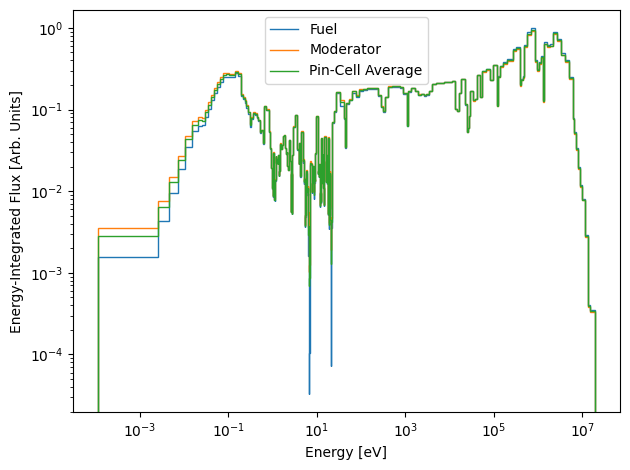

In [12]:
plt.stairs(fuel_flux, edges=ndl.group_bounds, label="Fuel")
plt.stairs(moderator_flux, edges=ndl.group_bounds, label="Moderator")
plt.stairs(avg_flux, edges=ndl.group_bounds, label="Pin-Cell Average")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Energy [eV]")
plt.ylabel("Energy-Integrated Flux [Arb. Units]")
plt.legend()
plt.tight_layout()
plt.show()

Since these values of the flux spectrum are integrated over the energy range of each group, they each have a unique normalization which depends on the energy width of the group. To fix this, we will divide each group by the energy width of the bin:

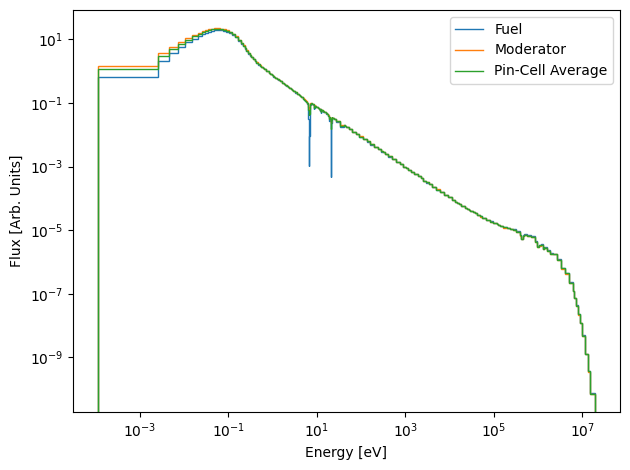

In [13]:
norm_fuel_flux = fuel_flux.copy()
norm_moderator_flux = moderator_flux.copy()
norm_avg_flux = avg_flux.copy()

for g in range(ndl.ngroups):
    delta_E = ndl.group_bounds[g] - ndl.group_bounds[g+1] # Group bounds also go from high to low energy !
    norm_fuel_flux[g] /= delta_E
    norm_moderator_flux[g] /= delta_E
    norm_avg_flux[g] /= delta_E

plt.stairs(norm_fuel_flux, edges=ndl.group_bounds, label="Fuel")
plt.stairs(norm_moderator_flux, edges=ndl.group_bounds, label="Moderator")
plt.stairs(norm_avg_flux, edges=ndl.group_bounds, label="Pin-Cell Average")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Energy [eV]")
plt.ylabel("Flux [Arb. Units]")
plt.legend()
plt.tight_layout()
plt.show()

This looks much more reasonable ! However, you might also be more accustomed to looking at the *lethargy normalized* flux spectrum, which we can also plot here:

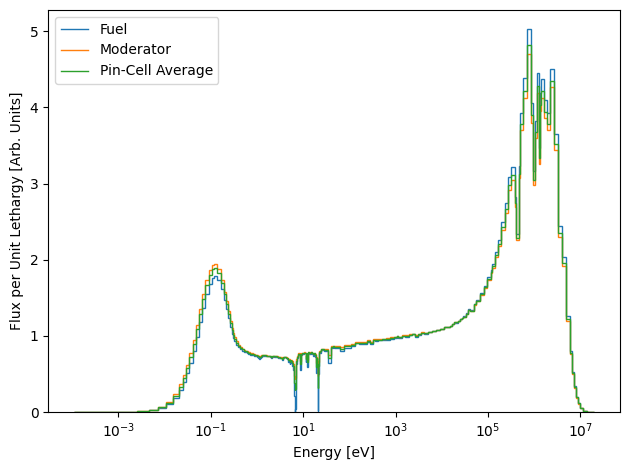

In [14]:
leth_norm_fuel_flux = fuel_flux.copy()
leth_norm_moderator_flux = moderator_flux.copy()
leth_norm_avg_flux = avg_flux.copy()

for g in range(ndl.ngroups):
    u = np.log(ndl.group_bounds[g] / ndl.group_bounds[g+1]) # Group bounds also go from high to low energy !
    leth_norm_fuel_flux[g] /= u
    leth_norm_moderator_flux[g] /= u
    leth_norm_avg_flux[g] /= u

plt.stairs(leth_norm_fuel_flux, edges=ndl.group_bounds, label="Fuel")
plt.stairs(leth_norm_moderator_flux, edges=ndl.group_bounds, label="Moderator")
plt.stairs(leth_norm_avg_flux, edges=ndl.group_bounds, label="Pin-Cell Average")
plt.xscale("log")
plt.xlabel("Energy [eV]")
plt.ylabel("Flux per Unit Lethargy [Arb. Units]")
plt.legend()
plt.tight_layout()
plt.show()

This is also likely to be a familiar results to most seasoned nuclear engineers. There is of course far more that can be done. We could use the `CylindricalFluxSolver` to homogenize the cross sections across the entire pin-cell for use in subsequent simulations. These flux spectra could also be used to condense the original cross sections for another calculation, like is done in the lattice physics calculation chain.